## Imports

The plotting utilities and various visualization tools for this notebook depend on [degas](https://github.com/williamgilpin/degas) and [tsfresh](https://tsfresh.readthedocs.io/en/latest/)

In [1]:
import sys

import matplotlib.pyplot as plt
import json

import pandas as pd
import dysts
from dysts.datasets import *
from dysts.utils import *



try:
    from degas import *
    import degas as dg
except ModuleNotFoundError:
    pass


FIGURE_PATH = "../private_writing/fig_resources/"

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Featurize many random initial conditions

In [16]:
# chunk and featurize several time windows
# EXPENSIVE: can bypass this and just import the features I found in the cell below

all_feature_dfs = list()
for i in np.linspace(0, 8000, 40).astype(int):
    dataset = TimeSeriesDataset("../dysts/data/large_univariate__pts_per_period_100__periods_100.json")
    dataset.trim_series(i, i + 2000)
    feature_df = featurize_timeseries(dataset)
    all_feature_dfs.append(feature_df)
    print(i, flush=True)
    
## Prune features not detected across all replicates
all_feature_lists = [set(item.columns.to_list()) for item in all_feature_dfs]
common_features = np.array(list(all_feature_lists[0].intersection(*all_feature_lists[1:])))
print(f"{len(common_features)} common features found.")
for i in range(len(all_feature_dfs)):
    all_feature_dfs[i] = all_feature_dfs[i][common_features]

rep_stds = np.std(np.dstack([np.array(df) for df in all_feature_dfs]), axis=-1)
topk_feature_inds = np.squeeze(np.array([np.argsort(np.median(rep_stds, axis=0))]))[:100]
feat_arr_all = np.dstack([np.array(df)[:, topk_feature_inds] for df in all_feature_dfs])
feat_arr_all = np.transpose(feat_arr_all, (2, 0, 1))
feat_arr_all.dump("benchmarks/resources/feat_arr_all2.pkl")


In [2]:
# Load output of cell above
dataset = TimeSeriesDataset("../dysts/data/large_univariate__pts_per_period_100__periods_100.json")
feat_arr_all = np.load("./resources/feat_arr_all.pkl", allow_pickle=True) 
features_mean = np.median(feat_arr_all, axis=0)
feat_arr_all_flat = np.reshape(feat_arr_all, (-1, feat_arr_all.shape[-1]))
feat_arr = features_mean

# Create an embedding using the centroids

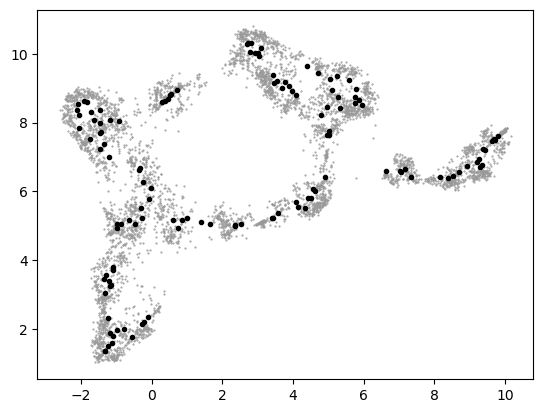

In [6]:
import umap
# model =  PCA(n_components=2, random_state=0)
# model = umap.UMAP(random_state=0, densmap=True)

# from umap.parametric_umap import ParametricUMAP
# model = ParametricUMAP(densmap=False)
model = umap.UMAP(random_state=15, n_neighbors=5)

embedding_mean = model.fit_transform(features_mean)
embedding_all = model.transform(feat_arr_all_flat)


plt.plot(embedding_all[:, 0], embedding_all[:, 1], '.', color=[0.6, 0.6, 0.6], markersize=1)
plt.plot(embedding_mean[:, 0], embedding_mean[:, 1], '.k')

Number of classes:  6


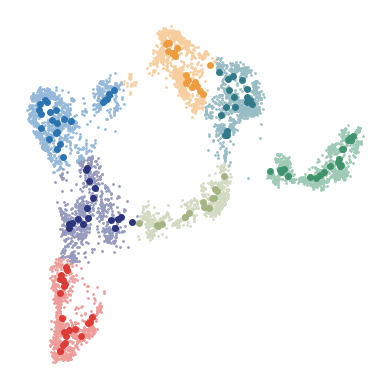

In [20]:
import hdbscan

from sklearn.cluster import AffinityPropagation
clusterer = AffinityPropagation()
labels_mean = clusterer.fit_predict(embedding_mean)
labels_all = clusterer.predict(embedding_all)

all_name_clusters = list()
print("Number of classes: ", len(np.unique(labels_mean)) - 1)
for label in np.unique(labels_mean):
    
    #if label >= 0:
    all_name_clusters.append(dataset.names[labels_mean == label])
    if label >= 0:
#         color_val = pastel_rainbow_interpolated[label]
        color_val = dg.pastel_rainbow[label]
#         color_val = dg.pastel_rainbow[label]
    else:
        color_val = (0.6, 0.6, 0.6)
    
    plt.plot(
        embedding_all[labels_all == label, 0], 
        embedding_all[labels_all == label, 1],  
        '.', 
        markersize=2, 
        color=dg.lighter(color_val, 0.5)
    )
    plt.plot(
        embedding_mean[labels_mean == label, 0], 
        embedding_mean[labels_mean == label, 1],  
        '.', 
        color=color_val,
        markersize=8
    )

fixed_aspect_ratio(1)
dg.vanish_axes()
# dg.better_savefig(FIGURE_PATH + "clustered_umap2.png")

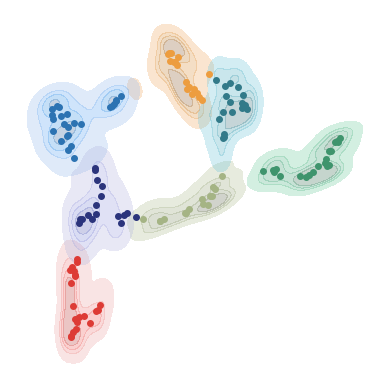

In [21]:
import seaborn as sns

ax = sns.kdeplot(x=embedding_all[:, 0], y=embedding_all[:, 1], hue=labels_all, 
            palette=sns.color_palette(dg.pastel_rainbow[:len(np.unique(labels_all))]), 
            shade=True, bw_adjust=1.3, levels=5)

for contour in ax.collections[:]:
    contour.set_alpha(0.3)
    
ax.grid(False)
ax.legend_.remove()

for label in np.unique(labels_mean):
    
    #if label >= 0:
    all_name_clusters.append(dataset.names[labels_mean == label])
    if label >= 0:
#         color_val = pastel_rainbow_interpolated[label]
        color_val = dg.pastel_rainbow[label]
#         color_val = dg.pastel_rainbow[label]
    else:
        color_val = (0.6, 0.6, 0.6)
    
#     plt.plot(
#         embedding_all[labels_all == label, 0], 
#         embedding_all[labels_all == label, 1],  
#         '.', 
#         markersize=2, 
#         color=dg.lighter(color_val, 0.5)
#     )
    plt.plot(
        embedding_mean[labels_mean == label, 0], 
        embedding_mean[labels_mean == label, 1],  
        '.', 
        color=color_val,
        markersize=8
    )
    
dg.fixed_aspect_ratio(1)
dg.vanish_axes()

# dg.better_savefig(FIGURE_PATH + "clustered_umap.png")

/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at l

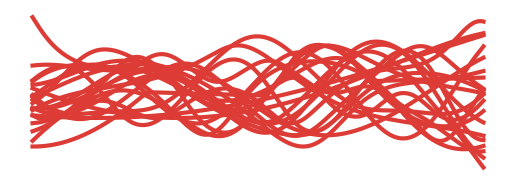

0   ['Arneodo' 'ArnoldBeltramiChildress' 'BlinkingRotlet' 'Bouali2'
 'CellularNeuralNetwork' 'Chua' 'Coullet' 'DequanLi' 'DoubleGyre'
 'Duffing' 'FluidTrampoline' 'GenesioTesi' 'GuckenheimerHolmes' 'Hadley'
 'HyperRossler' 'KawczynskiStrizhak' 'MultiChua' 'SprottD' 'SprottDelay'
 'StickSlipOscillator' 'YuWang2'] 
--------------



/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


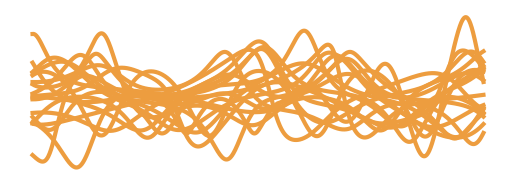

1   ['AnishchenkoAstakhov' 'BlinkingVortex' 'BurkeShaw' 'HyperLu' 'HyperPang'
 'HyperXu' 'HyperYangChen' 'Laser' 'Lorenz' 'LuChenCheng' 'NewtonLiepnik'
 'PanXuZhou' 'PehlivanWei' 'QiChen' 'SprottC' 'Tsucs2' 'VallisElNino'] 
--------------



/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


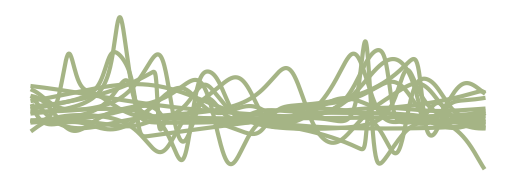

2   ['BelousovZhabotinsky' 'ChenLee' 'CoevolvingPredatorPrey' 'Dadras'
 'ExcitableCell' 'ForcedBrusselator' 'HindmarshRose' 'HyperYan'
 'ItikBanksTumor' 'LiuChen' 'Rucklidge' 'SprottB' 'SprottE' 'SprottTorus'
 'WangSun'] 
--------------



/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


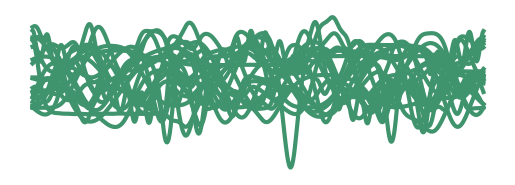

3   ['BeerRNN' 'DoublePendulum' 'HastingsPowell' 'JerkCircuit' 'Lorenz84'
 'Lorenz96' 'LuChen' 'MackeyGlass' 'OscillatingFlow' 'PiecewiseCircuit'
 'SprottF' 'SprottH' 'SprottL' 'SprottO' 'Thomas' 'ThomasLabyrinth'
 'Torus' 'TurchinHanski' 'VossDelay' 'YuWang'] 
--------------



/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


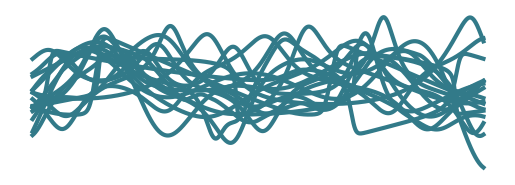

4   ['Aizawa' 'CaTwoPlus' 'CaTwoPlusQuasiperiodic' 'Chen' 'CircadianRhythm'
 'Finance' 'ForcedFitzHughNagumo' 'ForcedVanDerPol' 'Halvorsen'
 'HyperLorenz' 'LorenzCoupled' 'LorenzStenflo' 'MacArthur' 'MooreSpiegel'
 'RayleighBenard' 'Sakarya' 'SprottG'] 
--------------



/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


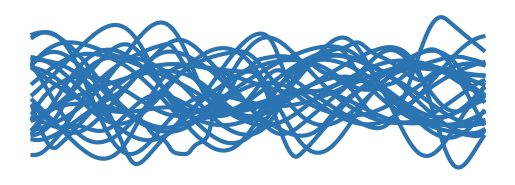

5   ['ArnoldWeb' 'BickleyJet' 'Blasius' 'CellCycle' 'Colpitts' 'HenonHeiles'
 'Hopfield' 'IkedaDelay' 'IsothermalChemical' 'NoseHoover'
 'NuclearQuadrupole' 'Rossler' 'SprottI' 'SprottJ' 'SprottJerk' 'SprottK'
 'SprottM' 'SprottMore' 'SprottN' 'SprottP' 'SprottQ' 'SprottR' 'SprottS'
 'WindmiReduced'] 
--------------



/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


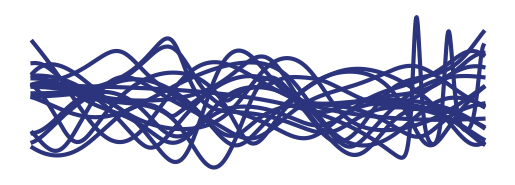

6   ['Bouali' 'HyperBao' 'HyperCai' 'HyperJha' 'HyperQi' 'HyperWang'
 'LorenzBounded' 'Qi' 'RabinovichFabrikant' 'RikitakeDynamo' 'SaltonSea'
 'SanUmSrisuchinwong' 'ScrollDelay' 'ShimizuMorioka' 'SprottA'
 'SwingingAtwood' 'ZhouChen'] 
--------------



In [22]:
import dysts.flows

for label, cluster in zip(np.unique(labels_mean), all_name_clusters):
    if label < 0:
        continue
    #print(label, cluster)
    color_val = dg.pastel_rainbow[label]
    plt.figure()
    for item in cluster:
        model_dyn = getattr(dysts.flows, item)()
        sol = model_dyn.make_trajectory(1000, resample=True, standardize=True, pts_per_period=500)
        #plt.plot(sol[:, 0], sol[:, 1], color=color_val)
        plt.plot(sol[:, 0], color=color_val, linewidth=3)
    fixed_aspect_ratio(1/3)
    dg.vanish_axes()
    dg.better_savefig(FIGURE_PATH + f"ts{label}.png")
    plt.show()
    
    print(label, " ", cluster, "\n--------------\n", flush=True)

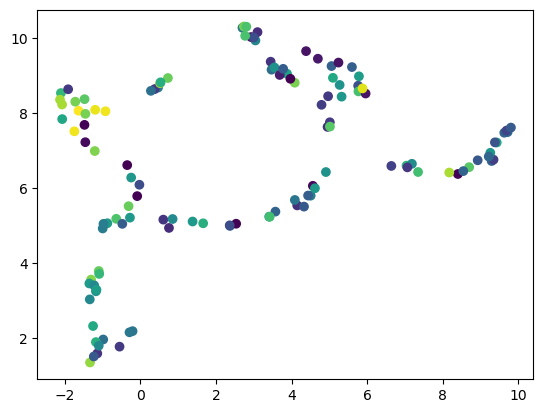

In [30]:
## Color by properties
import pandas as pd

df = pd.read_csv("~/program_repos/shrec/private_resources/entropy_rates.csv", index_col=0).transpose()

all_vals = list()
all_inds = list()
for i, name in enumerate(dataset.names):
    try:
       all_vals.append(df[name].values)
       all_inds.append(i)
    except KeyError:
        pass

all_vals = np.array(all_vals).squeeze()
all_inds = np.array(all_inds).squeeze()

plt.scatter(embedding_mean[all_inds, 0], embedding_mean[all_inds, 1], c=all_vals, cmap="viridis")

# Plot example dynamics

In [13]:
## Who is in each category?
np.array(all_name_clusters)[[0, 1, 2, 4, 5]]

<ipython-input-13-da2d0682a10f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(all_name_clusters)[[0, 1, 2, 4, 5]]


array([array(['Bouali2', 'Chua', 'Coullet', 'DequanLi', 'FluidTrampoline',
              'GuckenheimerHolmes', 'Hadley', 'HyperRossler',
              'KawczynskiStrizhak', 'SprottD', 'SprottDelay',
              'StickSlipOscillator', 'YuWang2'], dtype='<U23')            ,
       array(['BickleyJet', 'Blasius', 'CellCycle', 'HenonHeiles', 'Hopfield',
              'IkedaDelay', 'NoseHoover', 'NuclearQuadrupole', 'Rossler',
              'SprottI', 'SprottJ', 'SprottJerk', 'SprottM', 'SprottMore',
              'SprottN', 'SprottP', 'SprottS', 'WindmiReduced'], dtype='<U23'),
       array(['AnishchenkoAstakhov', 'ArnoldWeb', 'BlinkingVortex', 'BurkeShaw',
              'Colpitts', 'HyperLu', 'HyperPang', 'HyperXu', 'HyperYangChen',
              'IsothermalChemical', 'Laser', 'Lorenz', 'LuChenCheng',
              'NewtonLiepnik', 'PanXuZhou', 'PehlivanWei', 'QiChen', 'SprottC',
              'SprottK', 'SprottQ', 'SprottR', 'Tsucs2', 'VallisElNino'],
             dtype='<U23')        

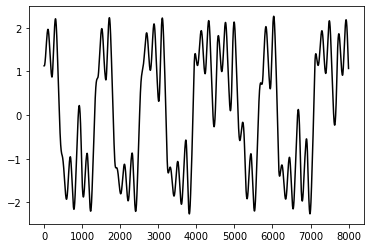

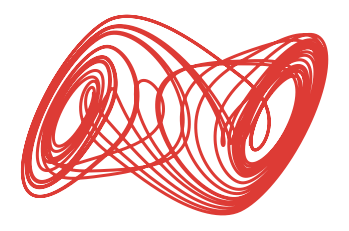

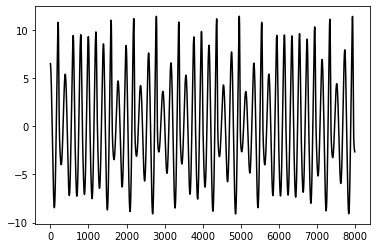

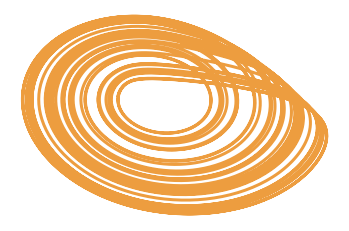

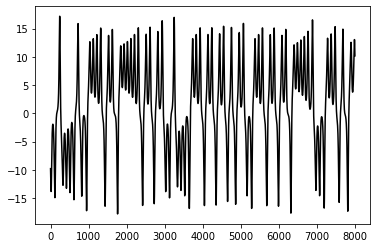

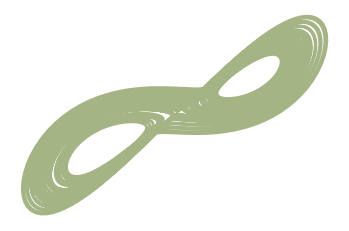

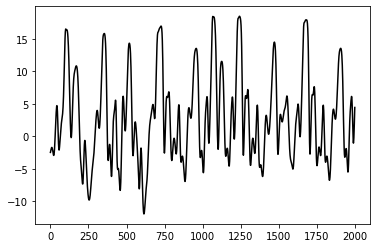

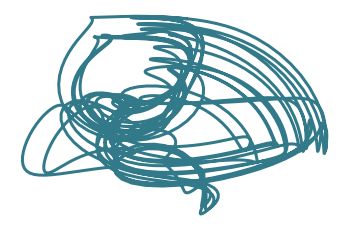

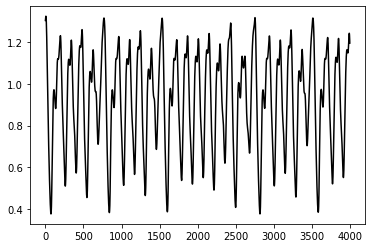

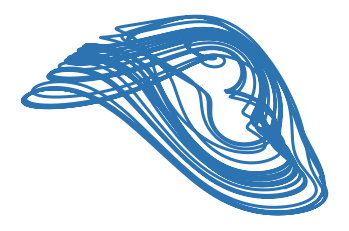

In [17]:
from dysts.flows import *


# eq = Lorenz84()
# eq = SprottA() # relaxation oscillator dynamics / spiking
# eq = ForcedFitzHughNagumo() #  nearly-quasiperiodic
# eq = Lorenz()
# eq = ArnoldBeltramiChildress() # ABC Turbulence


for clr_ind, equation_name in zip([0, 1, 2, 4, 5], ["Chua", "Rossler", "Lorenz", "Lorenz96", "MackeyGlass"]):
    
#     equation_name = all_name_clusters[clr_ind][3]
    
    eq = getattr(dysts.flows, equation_name)()
    # eq = HindmarshRose(); clr = dg.pastel_rainbow[0 % 8] # HindmarshRose neuron
    # eq = Colpitts(); clr = dg.pastel_rainbow[3 % 8] #Colpitts LC Circuit
#     eq = CaTwoPlus(); clr = dg.pastel_rainbow[5 % 8] # Quasiperiodic family
    clr = dg.pastel_rainbow[clr_ind]
    sol = eq.make_trajectory(8000, resample=True, pts_per_period=200)
    
    if equation_name == "Lorenz96":
        sol = eq.make_trajectory(2000, resample=True, pts_per_period=200)
        
    if equation_name == "MackeyGlass":
        sol = eq.make_trajectory(4000, resample=True, pts_per_period=200)

    plt.figure()
    plt.plot(sol[:, 0],  'k')

    plt.figure()
    plt.plot(sol[:, 0], sol[:, 1],  color=clr, linewidth=3)
    vanish_axes()
    if equation_name == "Lorenz":
        dg.better_savefig(FIGURE_PATH + f"sample_{equation_name}.png")

## Make histograms of attractor properties

In [8]:
import pandas as pd
import seaborn as sns

from dysts.systems import get_attractor_list

attributes =  ['maximum_lyapunov_estimated', 'kaplan_yorke_dimension', 'pesin_entropy', 'correlation_dimension', "multiscale_entropy"]
all_properties = dict()
for equation_name in get_attractor_list():
    eq = getattr(dysts.flows, equation_name)()
    
    
    
    attr_vals = [getattr(eq, item, np.nan) for item in attributes]
    
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    all_properties[equation_name]["dynamics_dimension"] = int(len(eq.ic))
    all_properties[equation_name]["lyapunov_scaled"] = all_properties[equation_name]["maximum_lyapunov_estimated"] * eq.period
    
all_properties = pd.DataFrame(all_properties).transpose()

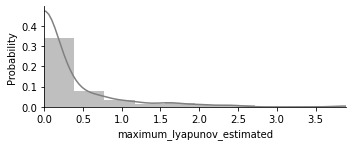

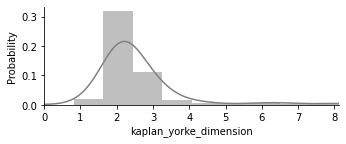

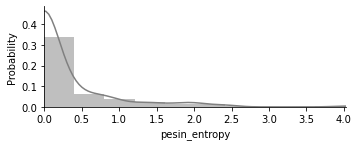

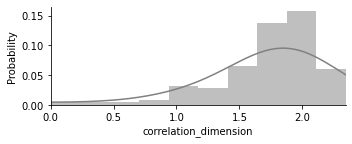

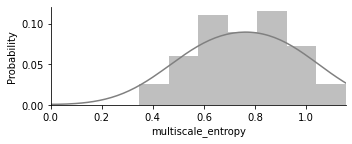

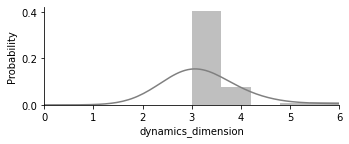

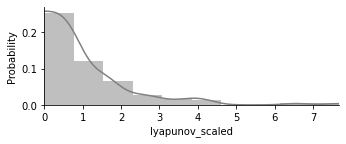

In [79]:
def mirror_df(df, mirror_val=0):
    """
    Create a mirrored augmented dataframe. Used
    for setting the right boundary conditions on kernel 
    density plots
    """
    return pd.concat([df, mirror_val - df])

sns.set_style()
dg.set_style()

for i, key in enumerate(all_properties.columns):
    
    reduced_df = all_properties[np.logical_not(np.isnan(all_properties[key]))]
    reduced_df = reduced_df[reduced_df[key] < np.percentile(reduced_df[key], 95)]
    reduced_df = mirror_df(reduced_df)


    sns.displot(reduced_df, 
                x=key, 
                kde=True,
                stat="probability",
                color=(0.5, 0.5, 0.5),
                linewidth=0,
                bins=20,
                #clip=(0.0, np.nanpercentile(all_properties[key], 99.5)),
                #kde=True, cut=0,
                kde_kws={"bw_method" : 0.2}
               )

    plt.xlim([0, np.max(reduced_df[key])])
    dg.fixed_aspect_ratio(1/3)
    dg.better_savefig(FIGURE_PATH + f"histogram_{key}.png")

# Create embedding and color by attractor properties

In [15]:
import umap
# model =  PCA(n_components=2, random_state=0)
# model = umap.UMAP(random_state=0, densmap=True)

# from umap.parametric_umap import ParametricUMAP
# model = ParametricUMAP(densmap=False)
model = umap.UMAP(random_state=15, n_neighbors=5)

embedding_mean = model.fit_transform(features_mean)
embedding_all = model.transform(feat_arr_all_flat)

In [20]:
import dysts.flows
from dysts.systems import get_attractor_list

max_lyap = list()
for equation_name in get_attractor_list():
    if equation_name == "AtmosphericRegime":
        continue
    eq = getattr(dysts.flows, equation_name)()
    max_lyap.append(eq.maximum_lyapunov_estimated)

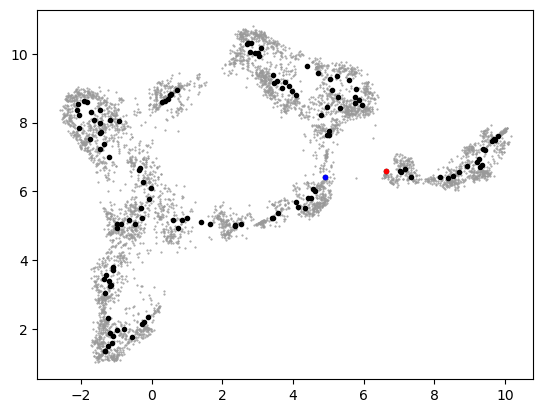

In [51]:

plt.plot(embedding_all[:, 0], embedding_all[:, 1], '.', color=[0.6, 0.6, 0.6], markersize=1)
plt.plot(embedding_mean[:, 0], embedding_mean[:, 1], '.k')

plt.plot(embedding_mean[128, 0], embedding_mean[128, 1], '.r')
plt.plot(embedding_mean[54, 0], embedding_mean[54, 1], '.b')

print